## Money Flow Index (MFI)
MFI is a Momentum oscillator which uses both price and volume to determine buying and selling pressure. Contrary to RSI which only uses price MFI also takes into account the volume to get better view of market strength.

### Intiution of MFI
- If MFI > 80 -> Security is overbought (sell signal)
- If MFI < 20 -> Security is oversold (buy signal)

### Calculating MFI
1. Typical price (TP) of each day:
$TP = \dfrac{\text{High + Low + Close}}{3}$

2. $\text{Raw Money Flow} = \text{Typical Price} * \text{Volume}$

3. Money Flow Direction
- If today's TP > yesterday's, positive money flow
- If today's TP < yesterday's, negative money flow

4. Sum over a window(usually 14)
- $\text{Positive Money Flow} = \sum{\text{Raw Money Flow (up days)}}$
- $\text{Negative Money Flow} = \sum{\text{Raw Money Flow (down days)}}$

5. Money Flow Ratio (MFR)
$MFR = \dfrac{\text{Positive Money Flow}}{\text{Negative Money Flow}}$

6. Money Flow Index
$MFI = 100 - \dfrac{100}{1+MFR}$

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

C:\Users\devpa\AppData\Local\Temp\ipykernel_20536\3153998435.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers=tickers, period='max')
[*********************100%***********************]  1 of 1 completed


Shows the postions we will be short(-1) and long(1) Strategy
 0    704
 1    225
-1     58
Name: count, dtype: int64


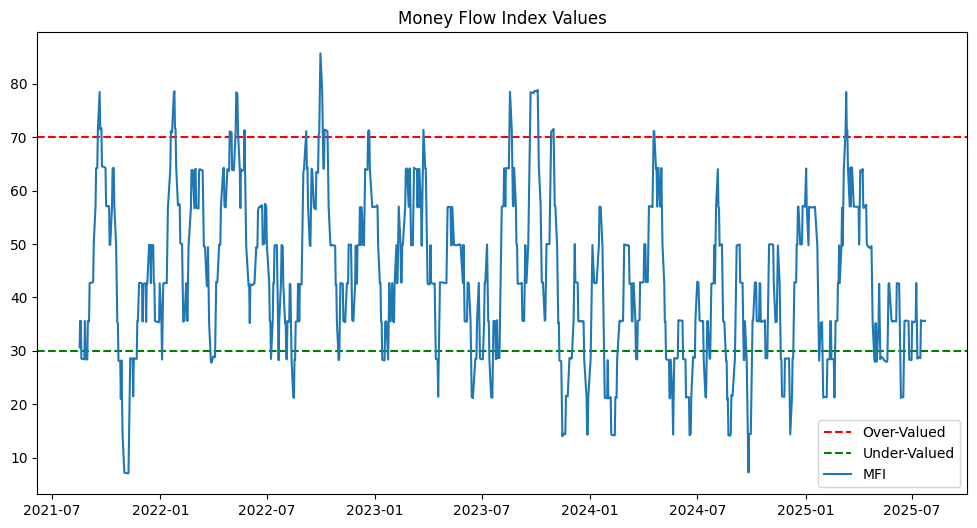

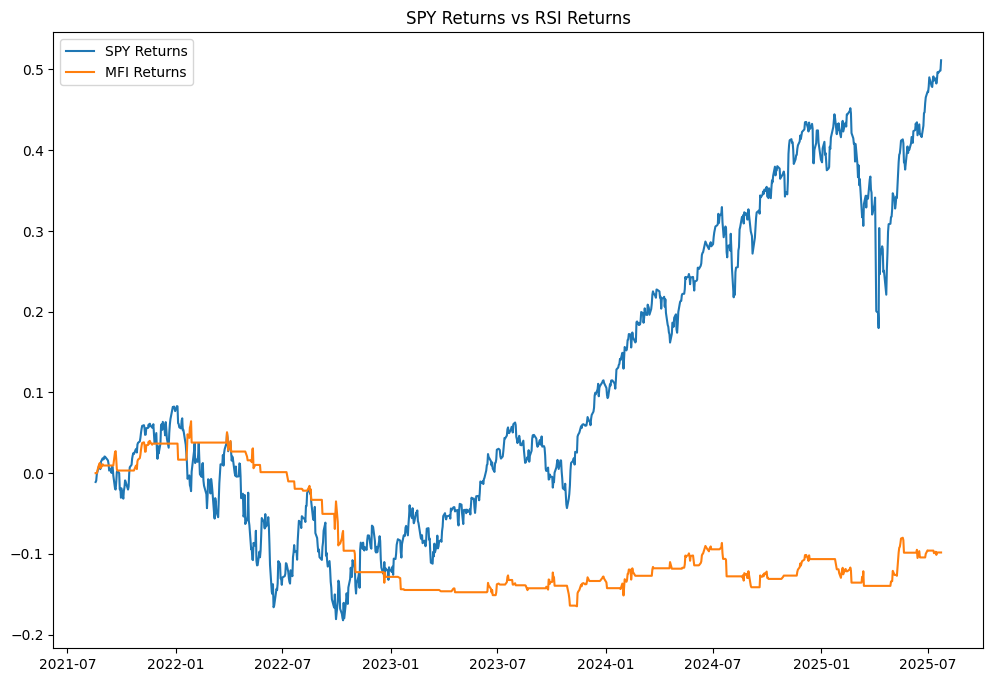

In [48]:
TICKER = 'SPY'
MFI_LENGTH = 14
OVERVALUED = 70
UNDERVALUED = 30
LOOKBACK = 1000

def get_data(tickers=TICKER):
    df = yf.download(tickers=tickers, period='max')
    df.columns = df.columns.get_level_values(0)
    return df.iloc[-LOOKBACK:, :]

def add_MFI(df):
    df["Typical_Price"] = (df["High"] + df["Low"] + df["Close"])/3
    df["Money_Flow"] = df["Typical_Price"] * df["Volume"]

    df["Positive_Flow"] = 0
    df["Negative_Flow"] = 0
    # pos and neg money flow
    df["Positive_Flow"] = np.where(df["Typical_Price"].diff() > 0, df["Typical_Price"], 0)
    df["Negative_Flow"] = np.where(df["Typical_Price"].diff() < 0, df["Typical_Price"], 0)

    # Money flow ratio
    mfr = df["Positive_Flow"].rolling(MFI_LENGTH).sum() / df["Negative_Flow"].rolling(MFI_LENGTH).sum()
    # Money flow index
    df["MFI"] = (100/(1 + mfr))
    plt.figure(figsize = (12,6))
    plt.title("Money Flow Index Values")
    plt.axhline(y=OVERVALUED, color='r', linestyle='--', label='Over-Valued')
    plt.axhline(y=UNDERVALUED, color='g', linestyle='--', label='Under-Valued')
    plt.plot(df["MFI"], label="MFI")
    plt.legend()
    return df.dropna()

# if a security is undervalue we by them and if they are overvalued we sell them
def add_strategy(df, overbought=OVERVALUED, oversold=UNDERVALUED):
    df["Strategy"] = 0
    df["Strategy"] = np.where(df["MFI"] > overbought, -1,
                        np.where(df["MFI"] < oversold, 1, 0))
    print("Shows the postions we will be short(-1) and long(1)",df["Strategy"].value_counts())
    # shift back to see that we see the signal
    df["Strategy"] = df["Strategy"].shift(1)
    return df

def test_strategy(df):
    df["Asset Returns"] = np.cumprod(1 + df["Close"].pct_change()) - 1
    df["Strategy Returns"] = np.cumprod(1 + df["Close"].pct_change() * df["Strategy"]) - 1
    plt.figure(figsize = (12, 8))
    plt.plot(df["Asset Returns"], label=f"{TICKER} Returns")
    plt.plot(df["Strategy Returns"], label=f"MFI Returns")
    plt.title(f"{TICKER} Returns vs RSI Returns")
    plt.legend()
    return df


def main():
    df = get_data()
    df = add_MFI(df)
    df = add_strategy(df)
    df = test_strategy(df)
    return df

df = main()

In [31]:
df

Price,Close,High,Low,Open,Volume,Typical_Price,Money_Flow,Positive_Flow,Negative_Flow,MFI
Date,,,,,,,,,,
2025-03-19,563.762451,567.559776,558.295110,559.487996,66556000,563.205779,3.748472e+10,563.205779,0.000000,61.626119
2025-03-20,562.132202,567.182055,559.259348,559.985055,62958200,562.857868,3.543652e+10,0.000000,562.857868,64.361178
2025-03-21,562.317627,563.224979,556.385213,557.631529,83763000,560.642606,4.696111e+10,0.000000,560.642606,64.257644
2025-03-24,572.387878,573.454732,568.519310,569.117517,58766800,571.453973,3.358252e+10,571.453973,0.000000,56.982459
2025-03-25,573.763794,574.710945,571.998992,573.604231,38355700,573.491244,2.199666e+10,573.491244,0.000000,57.007104
...,...,...,...,...,...,...,...,...,...,...
2025-07-17,628.039978,628.400024,624.179993,624.400024,68885700,626.873332,4.318261e+10,626.873332,0.000000,35.671510
2025-07-18,627.580017,629.469971,626.460022,629.299988,65621600,627.836670,4.119965e+10,627.836670,0.000000,35.615064
2025-07-21,628.770020,631.539978,628.340027,628.770020,63375000,629.550008,3.989773e+10,629.550008,0.000000,35.565369


#### Again as seen this is also a powerful tool but standalone it does not work in long run need learn combining strategies and tools in order to make a good standalone version.